In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
from tqdm import tqdm
import tqdm.notebook as tqdmnb

# managing files
from glob import glob
from shutil import copyfile
import pickle

# tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D, Conv2D, MaxPool2D, ZeroPadding2D, BatchNormalization, Input, DepthwiseConv2D, Add, LeakyReLU, ReLU
from tensorflow.keras.optimizers import Adam, SGD

# Audio
import librosa
import librosa.display as dsp
import IPython.display as ipd

# Augmentation
from audiomentations import Compose, AddGaussianNoise, TimeStretch, PitchShift, Shift

In [2]:
train_csv = pd.read_csv('data/train_data.csv')
train_csv

,id,age,gender,respiratory_condition,fever_or_muscle_pain,covid19
0,1,24,female,0,1,0
1,2,51,male,0,0,0
2,3,22,male,0,0,0
3,4,29,female,1,0,0
4,5,23,male,0,0,0
...,...,...,...,...,...,...
3800,3801,53,male,0,0,0
3801,3802,25,male,0,0,0
3802,3803,26,female,0,0,0
3803,3804,27,female,0,0,0


In [3]:
# Define Augmentation
augment = Compose([
    AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=0.5),
    TimeStretch(min_rate=0.8, max_rate=1.25, p=0.5),
    PitchShift(min_semitones=-4, max_semitones=4, p=0.5),
    Shift(min_fraction=-0.5, max_fraction=0.5, p=0.5),
])

In [4]:
train_path = glob('data/train/*.*')
len(train_path)

3805

In [5]:
# Audio augmentation
def path_to_mel(path, augmentation):
    audio, sr = librosa.load(path, sr=16000)

    if augmentation == True:
        audio = augment(samples=audio, sample_rate=16000)
        audio = np.hstack([audio, np.zeros(340000 - audio.shape[0])])

    elif augmentation == False:
        audio = np.hstack([audio, np.zeros(340000 - audio.shape[0])])
        
    mel = librosa.feature.melspectrogram(audio, sr=sr, n_mels=40)

    return np.array(mel, np.float64)

In [7]:
data = []
label = []

for i in tqdm(train_path):

    if train_csv.loc[int(i.split('/')[-1].split('.')[0]) - 1][5] == 1:
        data.append(path_to_mel(i, False))
        label.append(1)

        for j in range(5):
            data.append(path_to_mel(i, True))
            label.append(1)

    else:
        data.append(path_to_mel(i, False))
        label.append(0)

  0%|          | 0/3805 [00:00<?, ?it/s]/var/folders/8k/pkmq0wfd32q_r2nr5rcf2x1m0000gn/T/ipykernel_66999/246142194.py:12: FutureWarning: Pass y=[0. 0. 0. ... 0. 0. 0.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(audio, sr=sr, n_mels=40)
/var/folders/8k/pkmq0wfd32q_r2nr5rcf2x1m0000gn/T/ipykernel_66999/246142194.py:12: FutureWarning: Pass y=[ 0.00491847  0.00251543 -0.00035101 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(audio, sr=sr, n_mels=40)
/var/folders/8k/pkmq0wfd32q_r2nr5rcf2x1m0000gn/T/ipykernel_66999/246142194.py:12: FutureWarning: Pass y=[-0.00011307 -0.00537358 -0.00513119 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(audio, sr=sr, n_mels=40)

In [46]:
print(np.max(label), np.min(label))

1 0


In [43]:
BATCH_SIZE = 16
SHUFFLE_BUFFER_SIZE = 100
AUTOTUNE = tf.data.AUTOTUNE

train_ds = tf.data.Dataset.from_tensor_slices((data, label))
train_ds = train_ds.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)

2022-07-03 12:15:04.018685: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-07-03 12:15:04.019093: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



In [ ]:

input_shape = (4,)
print(f'Feature shape: {input_shape}')

model_sim = Sequential([
    layers.Dense(350, input_shape=input_shape, activation='relu'),
    layers.Dense(50, activation='relu'),
    layers.Dense(2, activation='relu'),
])

In [114]:
model_audio = Sequential([
  layers.Rescaling(1./255, input_shape=(40, 665, 1)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(2)
])

In [115]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [116]:
history = model.fit(train_ds, epochs=10)

Epoch 1/10


2022-07-03 18:54:45.898647: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


334/334 [==============================] - 13s 36ms/step - loss: 0.6079 - accuracy: 0.6679
Epoch 2/10
334/334 [==============================] - 11s 33ms/step - loss: 0.5612 - accuracy: 0.7089
Epoch 3/10
334/334 [==============================] - 11s 33ms/step - loss: 0.5165 - accuracy: 0.7458
Epoch 4/10
334/334 [==============================] - 11s 33ms/step - loss: 0.4742 - accuracy: 0.7558
Epoch 5/10
334/334 [==============================] - 11s 33ms/step - loss: 0.4017 - accuracy: 0.7979
Epoch 6/10
334/334 [==============================] - 11s 33ms/step - loss: 0.3249 - accuracy: 0.8437
Epoch 7/10
334/334 [==============================] - 11s 33ms/step - loss: 0.2523 - accuracy: 0.8776
Epoch 8/10
334/334 [==============================] - 11s 33ms/step - loss: 0.2238 - accuracy: 0.8918
Epoch 9/10
334/334 [==============================] - 11s 33ms/step - loss: 0.1914 - accuracy: 0.9031
Epoch 10/10
334/334 [==============================] - 11s 33ms/step - loss: 0.1607 - accurac

In [101]:
inf_path = glob('data/test/*.*')

inf_data = []
for i in tqdm(inf_path):
    inf_data.append(path_to_mel(i, False))

  0%|          | 0/5732 [00:00<?, ?it/s]/var/folders/8k/pkmq0wfd32q_r2nr5rcf2x1m0000gn/T/ipykernel_52724/246142194.py:12: FutureWarning: Pass y=[0. 0. 0. ... 0. 0. 0.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(audio, sr=sr, n_mels=40)
  0%|          | 9/5732 [00:02<29:31,  3.23it/s]/var/folders/8k/pkmq0wfd32q_r2nr5rcf2x1m0000gn/T/ipykernel_52724/246142194.py:12: FutureWarning: Pass y=[ 3.34500108e-08 -2.36135293e-07  4.83323220e-07 ...  0.00000000e+00
  0.00000000e+00  0.00000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(audio, sr=sr, n_mels=40)
  0%|          | 10/5732 [00:02<29:36,  3.22it/s]/var/folders/8k/pkmq0wfd32q_r2nr5rcf2x1m0000gn/T/ipykernel_52724/246142194.py:12: FutureWarning: Pass y=[ 3.34639800e-08 -2.36143691e-07  4.83321060e-07 ...  0.00000000e+00
  0.00000000e+00  0.00000000e+00]

In [117]:
with open('inf_data.pkl', 'wb') as f:
    pickle.dump(inf_data, f)

In [118]:
inf_data_pkl = []
with open('./inf_data.pkl', 'rb') as f:
    inf_data_pkl = pickle.load(f)

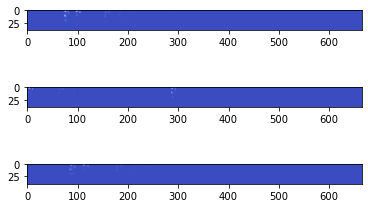

In [86]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm

plt.subplot(3, 1, 1)
plt.imshow(data[1], cmap=cm.coolwarm)
plt.subplot(3, 1, 2)
plt.imshow(data[2], cmap=cm.coolwarm)
plt.subplot(3, 1, 3)
plt.imshow(data[3], cmap=cm.coolwarm)

plt.show()

In [119]:
inf_data_reshaped = []

for i in tqdm(inf_data):
    inf_data_reshaped.append(i.reshape(-1, 40, 665, 1))

100%|██████████| 5732/5732 [00:00<00:00, 1364458.03it/s]


In [124]:
test_csv = pd.read_csv('data/test_data.csv')
test_csv

,id,age,gender,respiratory_condition,fever_or_muscle_pain
0,3806,48,female,1,0
1,3807,24,female,0,0
2,3808,29,male,0,0
3,3809,39,female,0,0
4,3810,34,male,0,0
...,...,...,...,...,...
5727,9533,43,male,0,0
5728,9534,48,female,0,1
5729,9535,44,female,0,0
5730,9536,25,female,0,0


In [120]:
# Model 추론
inf_result = []

for i in tqdmnb.tqdm(inf_data_reshaped):
    preds = model.predict(i)
    score = tf.nn.softmax(preds[0])
    class_names = [0,1]
    print('Answer is : ', class_names[np.argmax(score)])
    inf_result.append(class_names[np.argmax(score)])

  0%|          | 0/5732 [00:00<?, ?it/s]

1/1 [==============================] - 0s 237ms/step
Answer is :  0
1/1 [==============================] - 0s 10ms/step
Answer is :  0
1/1 [==============================] - 0s 23ms/step


2022-07-03 18:57:39.460687: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Answer is :  0
1/1 [==============================] - 0s 12ms/step
Answer is :  0
1/1 [==============================] - 0s 9ms/step
Answer is :  0
1/1 [==============================] - 0s 12ms/step
Answer is :  0
1/1 [==============================] - 0s 9ms/step
Answer is :  1
1/1 [==============================] - 0s 9ms/step
Answer is :  0
1/1 [==============================] - 0s 9ms/step
Answer is :  0
1/1 [==============================] - 0s 8ms/step
Answer is :  0
1/1 [==============================] - 0s 9ms/step
Answer is :  0
1/1 [==============================] - 0s 11ms/step
Answer is :  0
1/1 [==============================] - 0s 8ms/step
Answer is :  0
1/1 [==============================] - 0s 9ms/step
Answer is :  1
1/1 [==============================] - 0s 9ms/step
Answer is :  0
1/1 [==============================] - 0s 12ms/step
Answer is :  0
1/1 [==============================] - 0s 13ms/step
Answer is :  0
1/1 [==============================] - 0s 10ms/step
Answ

In [132]:
print(test_csv.loc[1][3] == 0, test_csv.loc[1][4] == 0)

True True


In [133]:
tmp = inf_result
for i in range(len(tmp)):
    if test_csv.loc[i][3] == 0 and test_csv.loc[i][4] == 0:
        print('trig')
        tmp[i] = 0
    else:
        continue

trig
trig
trig
trig
trig
trig
trig
trig
trig
trig
trig
trig
trig
trig
trig
trig
trig
trig
trig
trig
trig
trig
trig
trig
trig
trig
trig
trig
trig
trig
trig
trig
trig
trig
trig
trig
trig
trig
trig
trig
trig
trig
trig
trig
trig
trig
trig
trig
trig
trig
trig
trig
trig
trig
trig
trig
trig
trig
trig
trig
trig
trig
trig
trig
trig
trig
trig
trig
trig
trig
trig
trig
trig
trig
trig
trig
trig
trig
trig
trig
trig
trig
trig
trig
trig
trig
trig
trig
trig
trig
trig
trig
trig
trig
trig
trig
trig
trig
trig
trig
trig
trig
trig
trig
trig
trig
trig
trig
trig
trig
trig
trig
trig
trig
trig
trig
trig
trig
trig
trig
trig
trig
trig
trig
trig
trig
trig
trig
trig
trig
trig
trig
trig
trig
trig
trig
trig
trig
trig
trig
trig
trig
trig
trig
trig
trig
trig
trig
trig
trig
trig
trig
trig
trig
trig
trig
trig
trig
trig
trig
trig
trig
trig
trig
trig
trig
trig
trig
trig
trig
trig
trig
trig
trig
trig
trig
trig
trig
trig
trig
trig
trig
trig
trig
trig
trig
trig
trig
trig
trig
trig
trig
trig
trig
trig
trig
trig
trig
trig
trig


In [138]:
np.max(tmp)

1

In [137]:
submission = pd.read_csv('data/sample_submission.csv')
submission = submission.drop('covid19', 1)
submission['covid19'] = tmp
submission.to_csv('3layerCnn_fullData_augmentation_00drop.csv', index=False)

/var/folders/8k/pkmq0wfd32q_r2nr5rcf2x1m0000gn/T/ipykernel_52724/604763204.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  submission = submission.drop('covid19', 1)
